In [0]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM,Dense,Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn import linear_model

In [72]:
from google.colab import files
uploaded = files.upload()

Saving MSFT.csv to MSFT (2).csv


In [0]:
df_final = pd.read_csv("MSFT.csv",na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)

In [74]:
df_final.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.062549,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.064783,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.065899,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.064224,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.063107,47894400


In [75]:
df_final.shape

(8508, 6)

In [76]:
df_final.describe()

,Open,High,Low,Close,Adj Close,Volume
count,8508.000000,8508.000000,8508.000000,8508.000000,8508.000000,8.508000e+03
mean,27.963667,28.256448,27.663191,27.967167,23.151016,6.053323e+07
std,28.073135,28.293615,27.814854,28.069631,27.583079,3.891157e+07
min,0.088542,0.092014,0.088542,0.090278,0.058081,2.304000e+06
25%,3.373047,3.414063,3.343750,3.396485,2.185153,3.672762e+07
50%,26.160000,26.490000,25.860001,26.150000,18.411043,5.377450e+07
75%,34.095312,34.590938,33.666250,34.092500,25.329149,7.420815e+07
max,152.330002,152.500000,151.520004,152.320007,152.320007,1.031789e+09


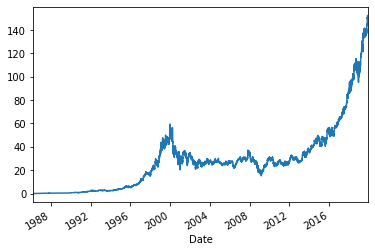

In [77]:
df_final['Open'].plot()

In [0]:
df_final=df_final.dropna()

In [79]:
df_final.isnull().any()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [80]:
X=df_final.drop(['Open'],axis=1)
X=X.drop(['Adj Close'],axis=1)
X.head()

,High,Low,Close,Volume
Date,,,,
1986-03-13,0.101563,0.088542,0.097222,1031788800
1986-03-14,0.102431,0.097222,0.100694,308160000
1986-03-17,0.103299,0.100694,0.102431,133171200
1986-03-18,0.103299,0.098958,0.099826,67766400
1986-03-19,0.100694,0.097222,0.098090,47894400


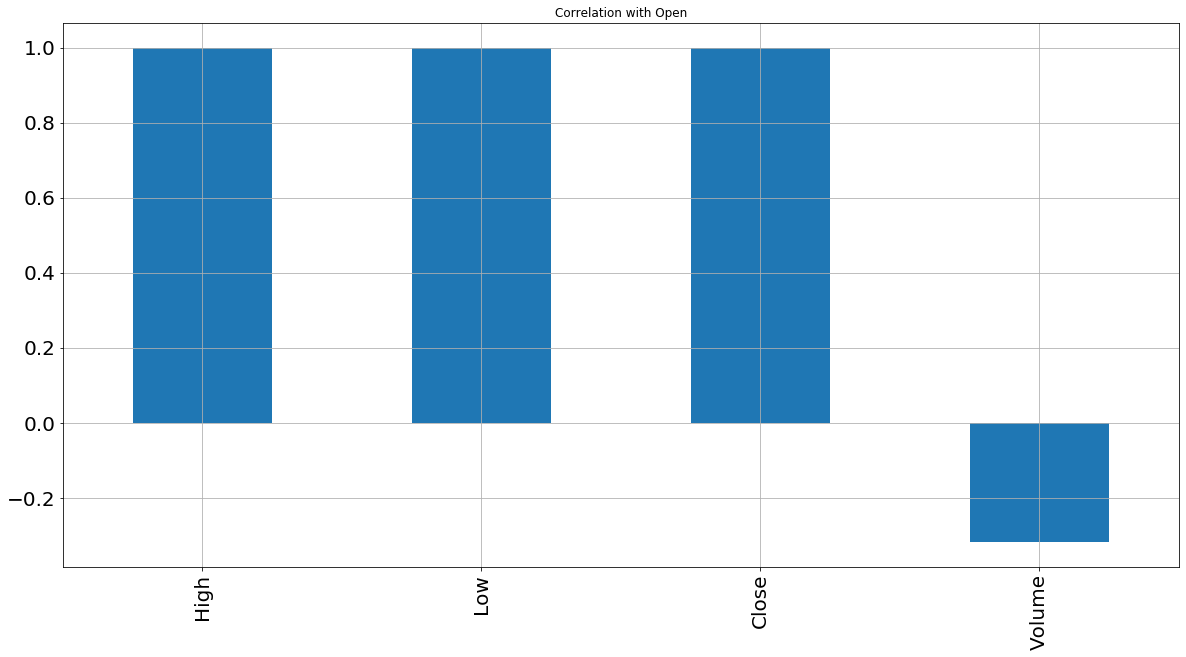

In [81]:
X.corrwith(df_final['Open']).plot.bar(
        figsize = (20, 10), title = "Correlation with Open", fontsize = 20,
        grid = True)

In [82]:
test = df_final
# Target column
target_open = pd.DataFrame(test['Open'])
display(test.head())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.062549,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.064783,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.065899,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.064224,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.063107,47894400


In [0]:
feature_columns = ['High', 'Low', 'Close']

In [84]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(test[feature_columns])
feature_minmax_transform = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data, index=test.index)
feature_minmax_transform.head()

,High,Low,Close
Date,,,
1986-03-13,0.000063,0.000000,0.000046
1986-03-14,0.000068,0.000057,0.000068
1986-03-17,0.000074,0.000080,0.000080
1986-03-18,0.000074,0.000069,0.000063
1986-03-19,0.000057,0.000057,0.000051


In [85]:
display(feature_minmax_transform.head())
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_open.shape)


target_open = target_open.shift(-1)
#target_open = target_open[:-90]

#feature_minmax_transform = feature_minmax_transform[:-90]


,High,Low,Close
Date,,,
1986-03-13,0.000063,0.000000,0.000046
1986-03-14,0.000068,0.000057,0.000068
1986-03-17,0.000074,0.000080,0.000080
1986-03-18,0.000074,0.000069,0.000063
1986-03-19,0.000057,0.000057,0.000051


Shape of features :  (8508, 3)
Shape of target :  (8508, 1)


In [0]:
ts_split= TimeSeriesSplit(n_splits=10)
for train_index, test_index in ts_split.split(feature_minmax_transform):
        X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target_open[:len(train_index)].values.ravel(), target_open[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [0]:
X_train =np.array(X_train)
X_test =np.array(X_test)

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [88]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(144, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/200
7735/7735 [==============================] - 6s 769us/step - loss: 2.2131
Epoch 2/200
7735/7735 [==============================] - 6s 793us/step - loss: 17.5008
Epoch 3/200
7735/7735 [==============================] - 6s 773us/step - loss: 7.4066
Epoch 4/200
7735/7735 [==============================] - 6s 792us/step - loss: 3.3653
Epoch 5/200
7735/7735 [==============================] - 6s 792us/step - loss: 1.9511
Epoch 6/200
7735/7735 [==============================] - 6s 767us/step - loss: 1.3941
Epoch 7/200
7735/7735 [==============================] - 6s 839us/step - loss: 1.1118
Epoch 8/200
7735/7735 [==============================] - 6s 834us/step - loss: 0.9299
Epoch 9/200
7735/7735 [==============================] - 6s 764us/step - loss: 0.7951
Epoch 10/200
7735/7735 [==============================] - 6s 719us/step - loss: 0.6816
Epoch 11/200
7735/7735 [==============================] - 6s 747us/step - loss: 0.5831
Epoch 12/200
7735/7735 [===========================

In [0]:
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

In [90]:
print(y_pred_test_LSTM[-1])

[185.39395]


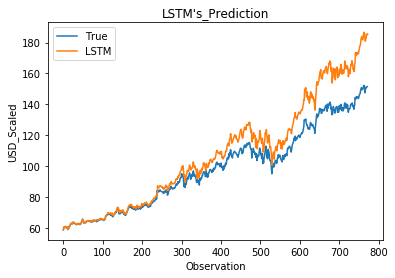

In [91]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('USD_Scaled')
plt.legend()
plt.show()


In [0]:
print(y_test[-1])

nan


In [0]:
col1 = pd.DataFrame(y_test, columns=['True'])

col2 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])

results = pd.concat([col1, col2], axis=1)
results.to_csv('PredictionResults.csv')

In [0]:
from google.colab import files
files.download('PredictionResults.csv') 

In [92]:
import joblib

joblib.dump(model_lstm, "microsoft.pkl")

['microsoft.pkl']

In [0]:
from google.colab import files
files.download('microsoft.pkl') 

In [0]:
df_final = pd.read_csv("AAPL.csv",na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)
X=df_final.drop(['Open'],axis=1)
X=X.drop(['Adj Close'],axis=1)
test = df_final
target_open = pd.DataFrame(test['Open'])
feature_columns = ['High', 'Low', 'Close']


In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(test[feature_columns])
feature_minmax_transform = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data, index=test.index)


In [0]:
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_open.shape)


target_open = target_open.shift(-1)
target_open = target_open[:-90]

feature_minmax_transform = feature_minmax_transform[:-90]

Shape of features :  (9813, 3)
Shape of target :  (9813, 1)


In [0]:
model = joblib.load("apple.pkl")

In [0]:
test = np.array(feature_minmax_transform[-1:])
test = test.reshape(1,1,3)
print(test)

print(model.predict(test))

[[[0.73255942 0.71695678 0.71383016]]]
[[181.11618]]
